In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import os

from cca.data_util import load_sabes_data, moving_center
from cca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_cross_cov_mats
from cca import ComplexityComponentsAnalysis
from cca.cca import DynamicalComponentsAnalysisFFT

In [14]:
NEURAL_DIR = os.path.expanduser("~") + "/Projects/ComplexityComponentsAnalysis/data/sabes/"
SESSION = "indy_20160627_01.mat" 
NEURAL_FILENAME = NEURAL_DIR + SESSION
BIN_WIDTH_S = .050

def load_neural_data():
    res = load_sabes_data(NEURAL_FILENAME, bin_width_s=BIN_WIDTH_S, preprocess=True)
    X, Y = res["M1"], res["cursor"]
    return X, Y

In [3]:
def dca_deflation(cross_cov_mats, n_proj, n_init=1):
    N = cross_cov_mats.shape[1]
    F = np.eye(N)
    cov_proj = np.copy(cross_cov_mats)
    basis = np.zeros((N, n_proj))
    opt = ComplexityComponentsAnalysis()
    for i in range(n_proj):
        if i % 10 == 0:
            print(i)
        #run DCA
        opt.cross_covs = cov_proj
        opt.fit_projection(d=1, n_init=n_init)
        v = opt.coef_.flatten()
        #get full-dim v
        v_full = np.dot(F, v)
        basis[:, i] = v_full
        #update U, F, cov_proj
        U = scipy.linalg.orth(np.eye(N - i) - np.outer(v, v))
        F = np.dot(F, U)
        cov_proj = np.array([U.T.dot(C).dot(U) for C in cov_proj])
    return basis

def dca_fft_deflation(X, T, n_proj, n_init=1):
    N = cross_cov_mats.shape[1]
    F = np.eye(N)
    X_proj = np.copy(X)
    basis = np.zeros((N, n_proj))
    opt = DynamicalComponentsAnalysisFFT(T=T)
    for i in range(n_proj):
        if i % 10 == 0:
            print(i)
        #run DCA
        opt.fit(X_proj, d=1, n_init=n_init)
        v = opt.coef_.flatten()
        #get full-dim v
        v_full = np.dot(F, v)
        basis[:, i] = v_full
        #update U, F, X
        U = scipy.linalg.orth(np.eye(N - i) - np.outer(v, v))
        F = np.dot(F, U)
        X_proj = np.dot(X_proj, U)
    return basis
        
def dca_full(cross_cov_mats, n_proj, n_init=1):
    opt = ComplexityComponentsAnalysis()
    opt.cross_covs = cross_cov_mats
    V_seq = []
    for i in range(n_proj):
        if i % 10 == 0:
            print(i)
        opt.fit_projection(d=i+1, n_init=n_init)
        V = opt.coef_
        V_seq.append(V)
    return V_seq

def calc_pi_vs_dim(cross_cov_mats, V=None, V_seq=None):
    if V_seq is None:
        V_seq = [V[:, :i+1] for i in range(V.shape[1])]
    pi_vals = np.zeros(len(V_seq))
    for i in range(len(V_seq)):
        V = V_seq[i]
        pi_vals[i] = calc_pi_from_cross_cov_mats(cross_cov_mats, proj=V)
    return pi_vals

In [15]:
#Run analysis for 3 methods(deflation, FFT+deflation, regular DCA)

T_pi = 5
n_proj = 20
n_init = 1

X, Y = load_neural_data()
cross_cov_mats = calc_cross_cov_mats_from_data(X, T=2*T_pi)

V_def = dca_deflation(cross_cov_mats, n_proj=n_proj, n_init=n_init)
V_fft = dca_fft_deflation(X, T=2*T_pi, n_proj=n_proj, n_init=n_init)
V_seq = dca_full(cross_cov_mats, n_proj=n_proj, n_init=n_init)

pi_def = calc_pi_vs_dim(cross_cov_mats, V=V_def)
pi_fft = calc_pi_vs_dim(cross_cov_mats, V=V_fft)
pi_regular = calc_pi_vs_dim(cross_cov_mats, V_seq=V_seq)

np.savez("cached_fig_data/def_comp_50ms.npz", pi_def=pi_def, pi_fft=pi_fft, pi_regular=pi_regular)

0
10
0
10
0
10


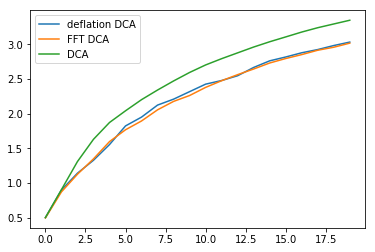

In [16]:
plt.plot(pi_def, label="deflation DCA")
plt.plot(pi_fft, label="FFT DCA")
plt.plot(pi_regular, label="DCA")
plt.legend()
plt.show()